In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet50
from torch.optim import Adam
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from timeit import default_timer as timer
from tqdm import tqdm

import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
# from torch.optim import Adam

from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Dict, List

In [2]:
try:
    from torchinfo import summary
    print("[INFO] torchinfo imported successfully")
except:
    print("[INFO] Could not find torchinfo. Installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
    print("[INFO] torchinfo installed and imported successfully.")

[INFO] torchinfo imported successfully


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
dataset_dir = Path("/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)")

print(dataset_dir)

/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)


In [5]:
train_dir = dataset_dir / "train"
val_dir = dataset_dir / "valid"
test_dir = Path("/kaggle/input/new-plant-diseases-dataset/test/test")

print(f"Train Directory : {train_dir}")
print(f"Validation Directory : {val_dir}")
print(f"Test Directory : {test_dir}")

Train Directory : /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Validation Directory : /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
Test Directory : /kaggle/input/new-plant-diseases-dataset/test/test


In [6]:
total_class_train = len(os.listdir(train_dir))
total_class_val = len(os.listdir(val_dir))
total_test = len(os.listdir(test_dir))

print(f"Total of Train Data Classes: {total_class_train} classes")
print(f"Total of Validation Data Classes: {total_class_val} classes")
print(f"Total of Test Data: {total_test} images")

Total of Train Data Classes: 38 classes
Total of Validation Data Classes: 38 classes
Total of Test Data: 33 images


In [7]:
def count_data_per_class(path):
    classes = sorted(os.listdir(path))
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(path, cls)
        class_counts[cls] = len(os.listdir(class_path))
    return class_counts

In [8]:
train_class_counts = count_data_per_class(train_dir)
val_class_counts = count_data_per_class(val_dir)

In [9]:
train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])
val_counts_df = pd.DataFrame.from_dict(val_class_counts, orient="index", columns=["Count"])

In [10]:
print(f"Total Image for Training: {sum(train_class_counts.values())} images")
print(f"Total Image for Validation: {sum(val_class_counts.values())} images")


Total Image for Training: 70295 images
Total Image for Validation: 17572 images


In [11]:
train_counts_df

Count
Apple___Apple_scab                                   2016
Apple___Black_rot                                    1987
Apple___Cedar_apple_rust                             1760
Apple___healthy                                      2008
Blueberry___healthy                                  1816
Cherry_(including_sour)___Powdery_mildew             1683
Cherry_(including_sour)___healthy                    1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   1642
Corn_(maize)___Common_rust_                          1907
Corn_(maize)___Northern_Leaf_Blight                  1908
Corn_(maize)___healthy                               1859
Grape___Black_rot                                    1888
Grape___Esca_(Black_Measles)                         1920
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)           1722
Grape___healthy                                      1692
Orange___Haunglongbing_(Citrus_greening)             2010
Peach___Bacterial_spot                               1838
Peach___healthy                                      1728
Pepper,_bell___Bacterial_spot                        1913
Pepper,_bell___healthy                               1988
Potato___Early_blight                                1939
Potato___Late_blight                                 1939
Potato___healthy                                     1824
Raspberry___healthy                                  1781
Soybean___healthy                                    2022
Squash___Powdery_mildew                              1736
Strawberry___Leaf_scorch                             1774
Strawberry___healthy                                 1824
Tomato___Bacterial_spot                              1702
Tomato___Early_blight                                1920
Tomato___Late_blight                                 1851
Tomato___Leaf_Mold                                   1882
Tomato___Septoria_leaf_spot                          1745
Tomato___Spider_mites Two-spotted_spider_mite        1741
Tomato___Target_Spot                                 1827
Tomato___Tomato_Yellow_Leaf_Curl_Virus               1961
Tomato___Tomato_mosaic_virus                         1790
Tomato___healthy                                     1926

In [12]:
val_counts_df


Count
Apple___Apple_scab                                    504
Apple___Black_rot                                     497
Apple___Cedar_apple_rust                              440
Apple___healthy                                       502
Blueberry___healthy                                   454
Cherry_(including_sour)___Powdery_mildew              421
Cherry_(including_sour)___healthy                     456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot    410
Corn_(maize)___Common_rust_                           477
Corn_(maize)___Northern_Leaf_Blight                   477
Corn_(maize)___healthy                                465
Grape___Black_rot                                     472
Grape___Esca_(Black_Measles)                          480
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)            430
Grape___healthy                                       423
Orange___Haunglongbing_(Citrus_greening)              503
Peach___Bacterial_spot                                459
Peach___healthy                                       432
Pepper,_bell___Bacterial_spot                         478
Pepper,_bell___healthy                                497
Potato___Early_blight                                 485
Potato___Late_blight                                  485
Potato___healthy                                      456
Raspberry___healthy                                   445
Soybean___healthy                                     505
Squash___Powdery_mildew                               434
Strawberry___Leaf_scorch                              444
Strawberry___healthy                                  456
Tomato___Bacterial_spot                               425
Tomato___Early_blight                                 480
Tomato___Late_blight                                  463
Tomato___Leaf_Mold                                    470
Tomato___Septoria_leaf_spot                           436
Tomato___Spider_mites Two-spotted_spider_mite         435
Tomato___Target_Spot                                  457
Tomato___Tomato_Yellow_Leaf_Curl_Virus                490
Tomato___Tomato_mosaic_virus                          448
Tomato___healthy                                      481

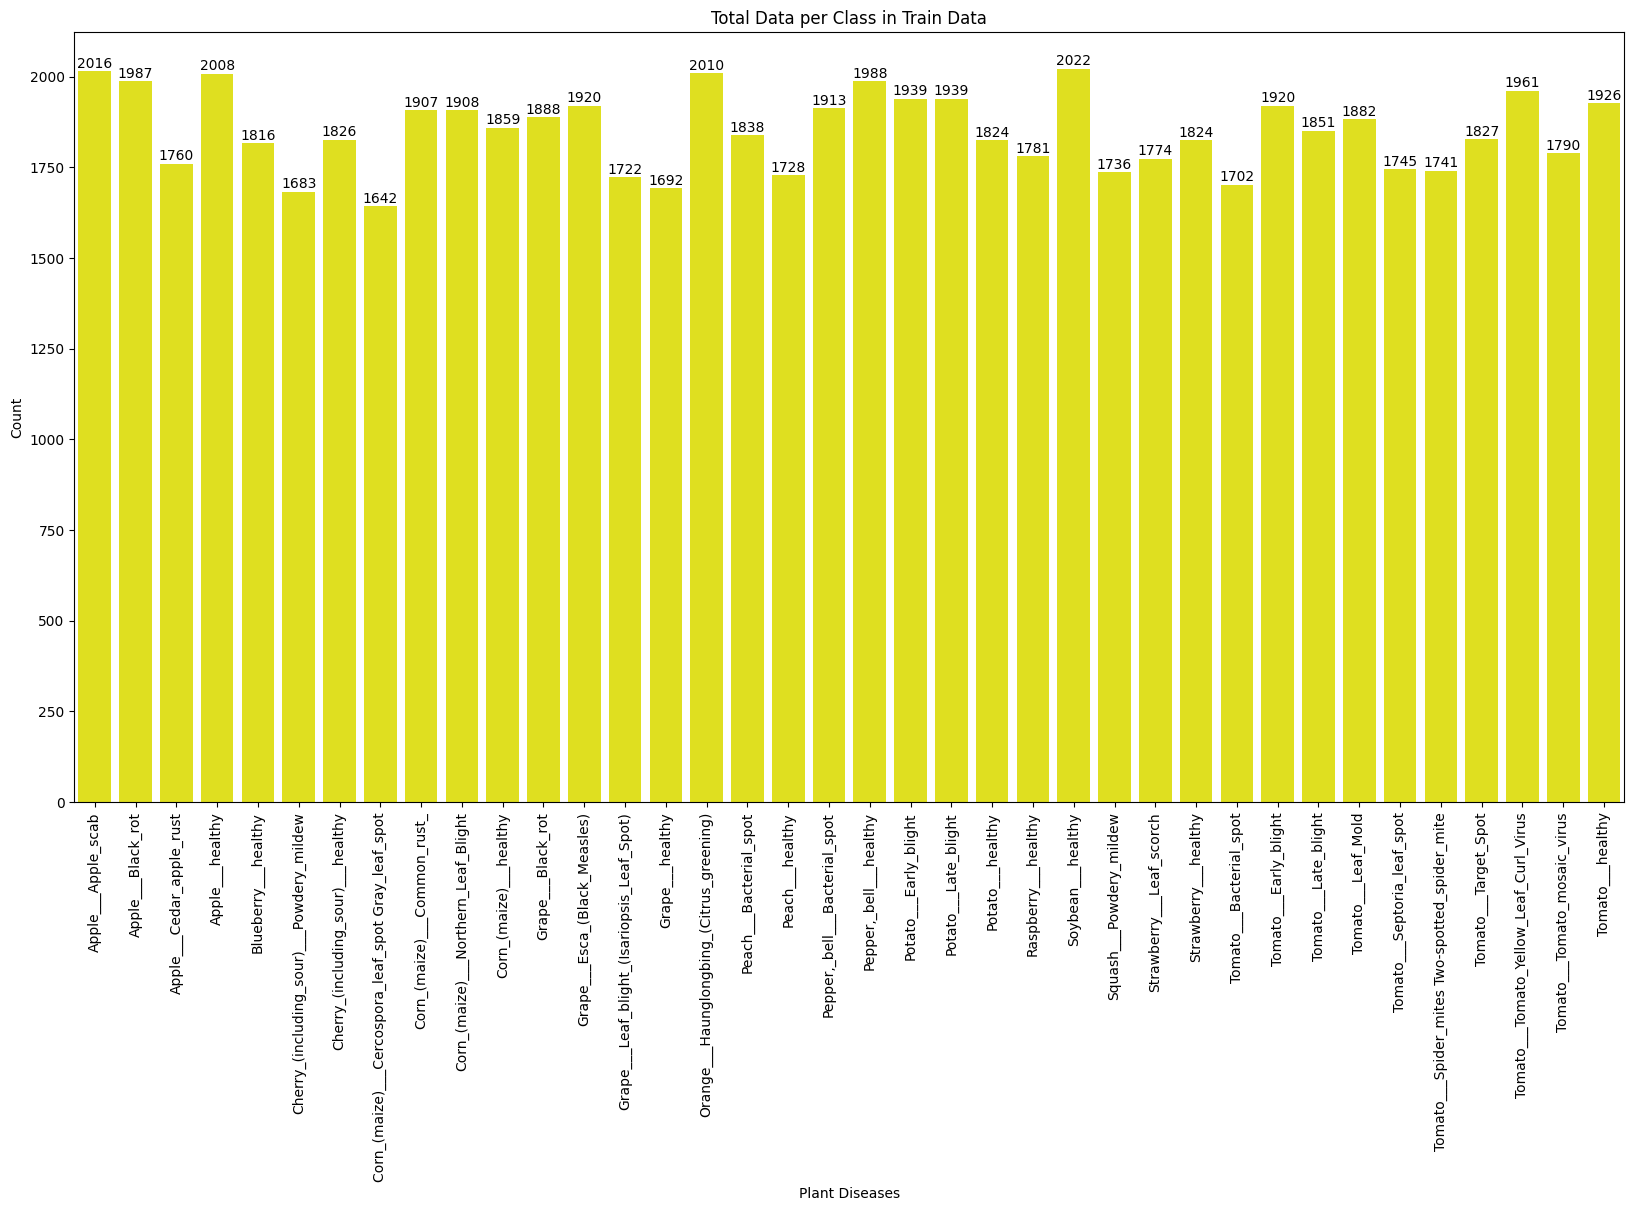

In [13]:
plt.figure(figsize=(20, 10))
sns.barplot(data=train_counts_df, x=train_counts_df.index, y="Count", color="yellow")
plt.title("Total Data per Class in Train Data")
plt.xlabel("Plant Diseases")
plt.ylabel("Count")
plt.xticks(rotation=90)

# get the current axes to make the number label on top each bar
ax = plt.gca()

# add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., 
            p.get_height()+10,
            '{:1.0f}'.format(p.get_height()),
            ha="center") 

# saving plot
plt.savefig("Total Data per Class in Train Data.jpg")

# show the plot
plt.show()


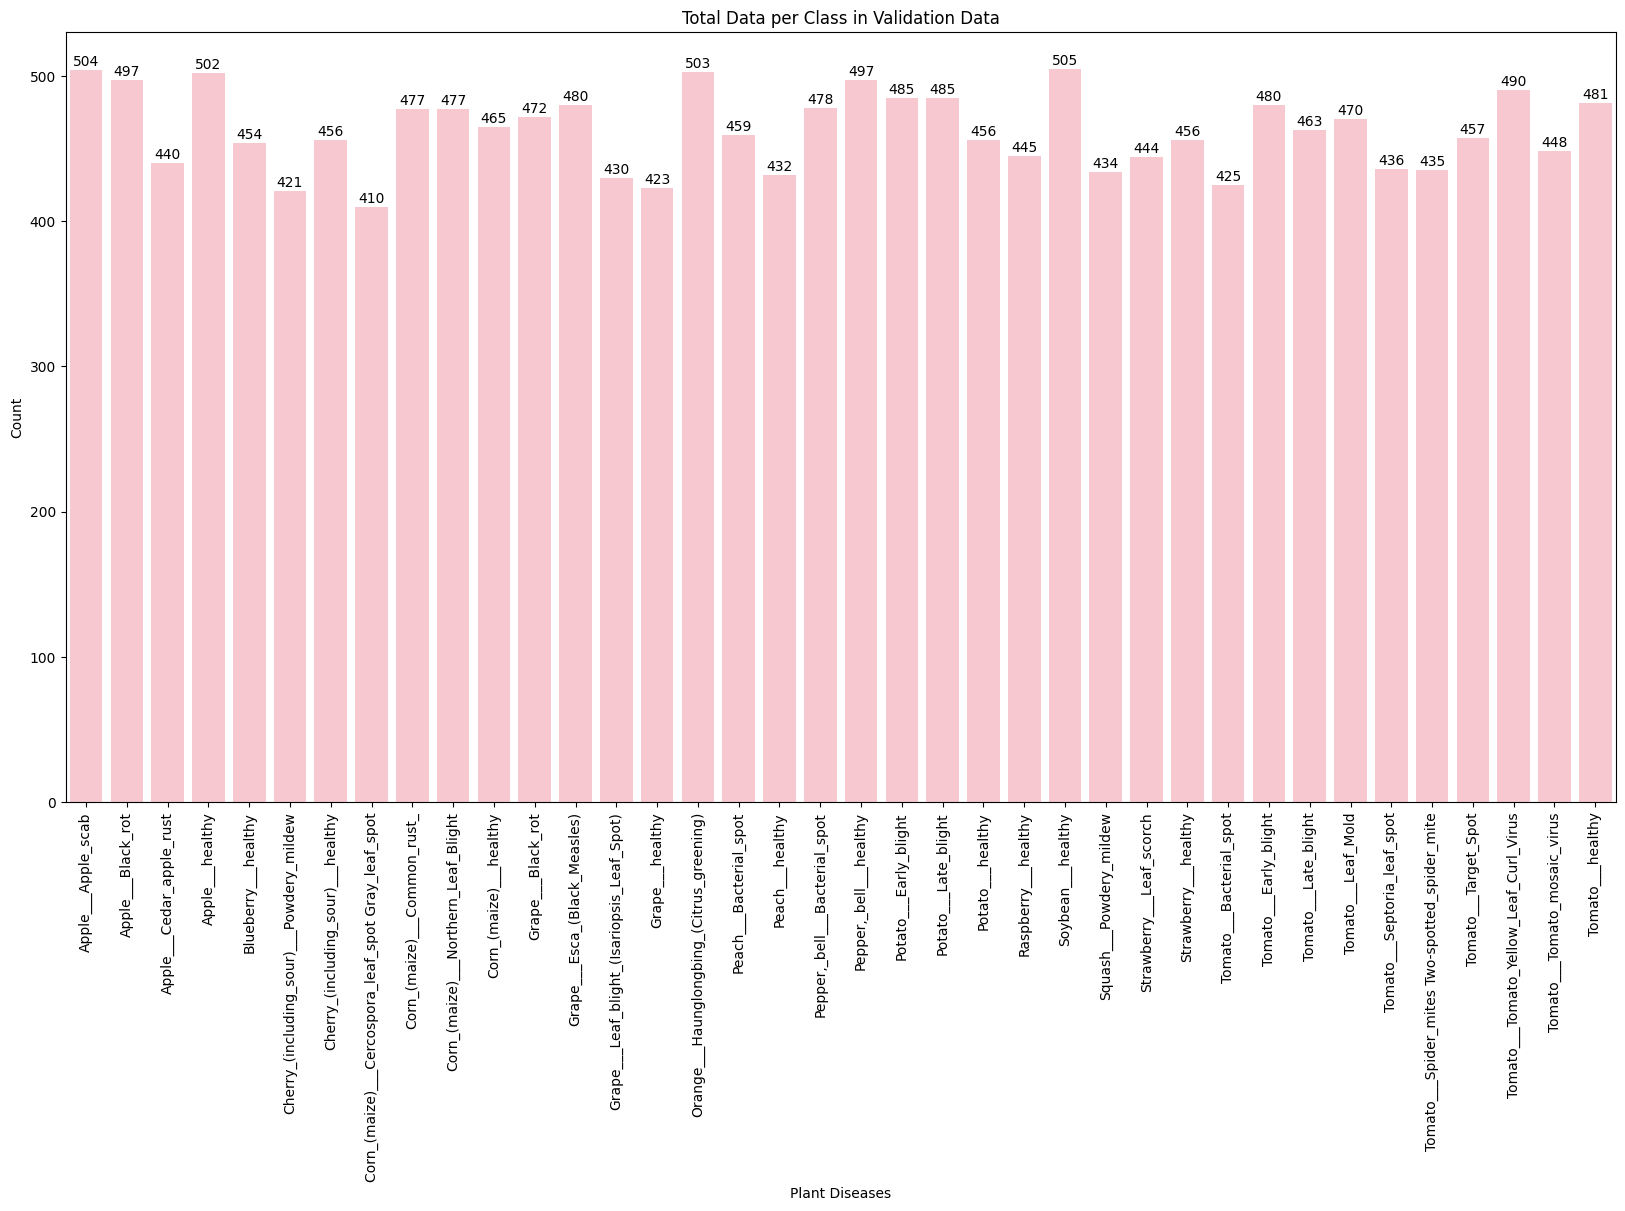

In [14]:
plt.figure(figsize=(20, 10))
sns.barplot(data=val_counts_df, x=val_counts_df.index, y="Count", color="pink")
plt.title("Total Data per Class in Validation Data")
plt.xlabel("Plant Diseases")
plt.ylabel("Count")
plt.xticks(rotation=90)

# get the current axes to make the number label on top each bar
ax = plt.gca()

# add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., 
            p.get_height()+3, 
            '{:1.0f}'.format(p.get_height()),
            ha="center") 

# saving plot
plt.savefig("Total Data per Class in Validation Data.jpg")
plt.show()

In [15]:
all_diseases = sorted(os.listdir(train_dir))

plants = []
for cls in all_diseases:
    plant = cls.split("___")[0]
    if plant not in plants:
        plants.append(plant)

num_plants = len(plants)
print(f"Number of Plants: {num_plants} plants")
print("Kind of Plants: ")
for i, plant in enumerate(plants):
    print(f"{i+1}. {plant}")

diseases = []
for cls in all_diseases:
    disease = cls.split("___")[1]
    if disease not in diseases:
        if disease != "healthy":
            diseases.append(disease)
    
num_diseases = len(diseases)
print(f"\nNumber of Diseases: {num_diseases} diseases")
print("Kind of Diseases: ")
for i, disease in enumerate(diseases):
    print(f"{i+1}. {disease}")

Number of Plants: 14 plants
Kind of Plants: 
1. Apple
2. Blueberry
3. Cherry_(including_sour)
4. Corn_(maize)
5. Grape
6. Orange
7. Peach
8. Pepper,_bell
9. Potato
10. Raspberry
11. Soybean
12. Squash
13. Strawberry
14. Tomato

Number of Diseases: 20 diseases
Kind of Diseases: 
1. Apple_scab
2. Black_rot
3. Cedar_apple_rust
4. Powdery_mildew
5. Cercospora_leaf_spot Gray_leaf_spot
6. Common_rust_
7. Northern_Leaf_Blight
8. Esca_(Black_Measles)
9. Leaf_blight_(Isariopsis_Leaf_Spot)
10. Haunglongbing_(Citrus_greening)
11. Bacterial_spot
12. Early_blight
13. Late_blight
14. Leaf_scorch
15. Leaf_Mold
16. Septoria_leaf_spot
17. Spider_mites Two-spotted_spider_mite
18. Target_Spot
19. Tomato_Yellow_Leaf_Curl_Virus
20. Tomato_mosaic_virus


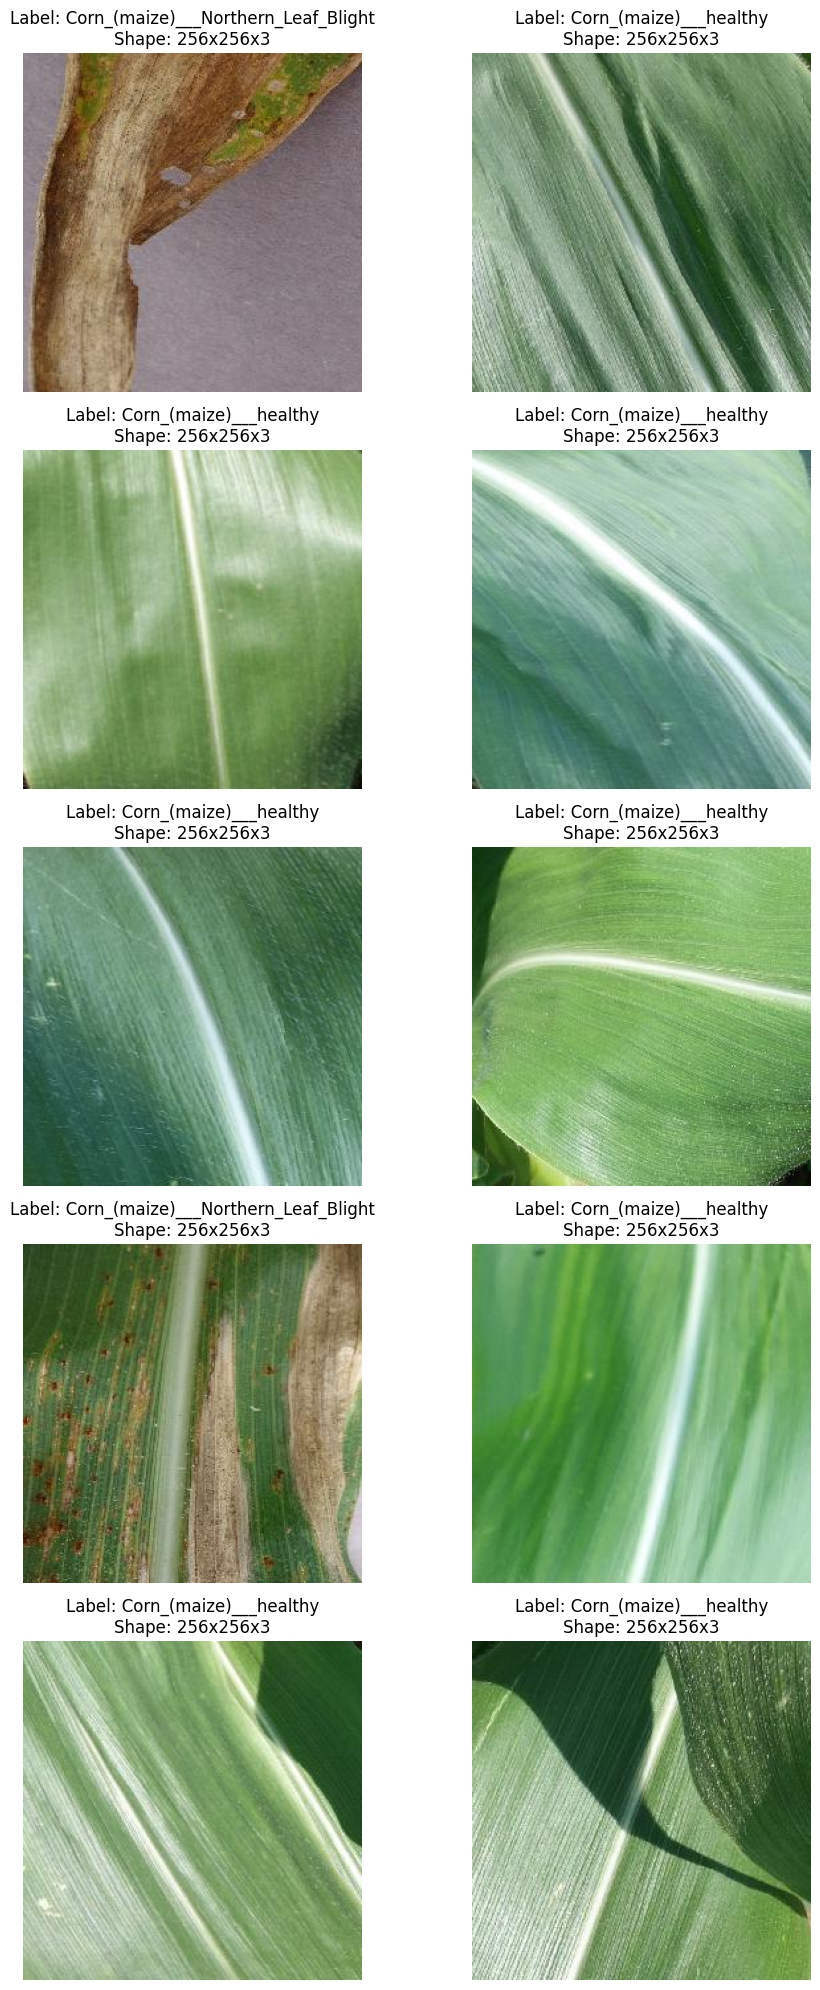

In [16]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Get all the image paths
image_path_list = list(dataset_dir.glob("*/*/*.jpg"))

# Choose 10 image paths randomly
random_image_paths = random.sample(image_path_list, 10)

# Define the subplot
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

# Display 10 images randomly
for i, ax in enumerate(axes.flat):
    random_image_path = random_image_paths[i]  # Get image path
    image_class = random_image_path.parent.stem  # Get image class from path name as label
    image = Image.open(random_image_path)  # Open image
    ax.imshow(image)  # Display image on subplot
    
    # Add label and shape of the image
    ax.set_title(f"Label: {image_class}\nShape: {image.height}x{image.width}x{3 if image.mode == 'RGB' else 1}")
    ax.axis("off")  # Turn off axes

plt.tight_layout()
plt.show()



In [17]:
train_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    # do not augment in validation data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [18]:
train_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    # do not augment in validation data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
train_transform_ev2 = transforms.Compose([
    transforms.Resize(size=384, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=384),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_ev2 = transforms.Compose([
    transforms.Resize(size=384, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=384),
    # do not augment in validation data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
train_dataset_rn50 = datasets.ImageFolder(root=train_dir, transform=train_transform_rn50)
val_dataset_rn50 = datasets.ImageFolder(root=val_dir, transform=val_transform_rn50)

# ImageFolder for EfficientNet V2 model
train_dataset_ev2 = datasets.ImageFolder(root=train_dir, transform=train_transform_ev2)
val_dataset_ev2 = datasets.ImageFolder(root=val_dir, transform=val_transform_ev2)

# display classes of ImageFolder dataset
print(f"Dataset Classes: {len(train_dataset_ev2.classes)}\n")
train_dataset_ev2.classes

Dataset Classes: 38



['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [21]:
train_dataloader_rn50 = DataLoader(train_dataset_rn50,
                                   batch_size=32,
                                   num_workers=2,
                                   shuffle=True)

val_dataloader_rn50 = DataLoader(val_dataset_rn50,
                                 batch_size=32,
                                 num_workers=2,
                                 shuffle=False) # do not shuffle on validation data

# create DataLoader for EfficientNet V2 model
train_dataloader_ev2 = DataLoader(train_dataset_ev2,
                                  batch_size=32,
                                  num_workers=2,
                                  shuffle=True)

val_dataloader_ev2 = DataLoader(val_dataset_ev2,
                                batch_size=32,
                                num_workers=2,
                                shuffle=False)  # do not shuffle on validation data


print(f"Number of Train Dataloader: {len(train_dataloader_ev2)} batches")
print(f"Number of Validation Dataloader: {len(val_dataloader_ev2)} batches")

Number of Train Dataloader: 2197 batches
Number of Validation Dataloader: 550 batches


In [22]:
# looking information inside dataloader has made: ResNet50

# get the batch sample in the dataloader
# dataloader contains input and output (feature and label)
images, labels = next(iter(train_dataloader_rn50))

# get the number of batches in the dataloader
num_batches = len(train_dataloader_rn50)

# print out the summary
print("[DATALOADER FOR RESNET50 MODEL]\n")
print(f"Train Dataloader = {train_dataloader_rn50}\n")
print(f"Batch Sample:\nImage Shape = {images.shape}\nLabel Shape = {labels.shape}\nLabels = {labels.tolist()}")
print(f"Number of Batches = {num_batches} batches")
print(f"Number of All Data = {32*num_batches} images")

[DATALOADER FOR RESNET50 MODEL]

Train Dataloader = <torch.utils.data.dataloader.DataLoader object at 0x785df1a11b70>

Batch Sample:
Image Shape = torch.Size([32, 3, 224, 224])
Label Shape = torch.Size([32])
Labels = [31, 26, 7, 2, 16, 26, 24, 12, 8, 27, 27, 33, 36, 2, 21, 8, 21, 26, 30, 17, 13, 7, 17, 9, 27, 10, 33, 31, 36, 22, 29, 7]
Number of Batches = 2197 batches
Number of All Data = 70304 images


In [23]:
# looking information inside dataloader has made: EfficientNet V2

# get the batch sample in the dataloader
# dataloader contains input and output (feature and label)
images, labels = next(iter(train_dataloader_ev2))

# get the number of batches in the dataloader
num_batches = len(train_dataloader_ev2)

# print out the summary
print("[DATALOADER FOR EFFICIENTNET V2 MODEL]\n")
print(f"Train Dataloader = {train_dataloader_ev2}\n")
print(f"Batch Sample:\nImage Shape = {images.shape}\nLabel Shape = {labels.shape}\nLabels = {labels.tolist()}")
print(f"Number of Batches = {num_batches} batches")
print(f"Number of All Data = {32*num_batches} images")

[DATALOADER FOR EFFICIENTNET V2 MODEL]

Train Dataloader = <torch.utils.data.dataloader.DataLoader object at 0x785df1a11b40>

Batch Sample:
Image Shape = torch.Size([32, 3, 384, 384])
Label Shape = torch.Size([32])
Labels = [8, 32, 24, 12, 29, 9, 26, 18, 35, 7, 30, 36, 25, 3, 19, 12, 25, 26, 19, 1, 32, 36, 9, 37, 27, 22, 20, 15, 35, 15, 13, 0]
Number of Batches = 2197 batches
Number of All Data = 70304 images


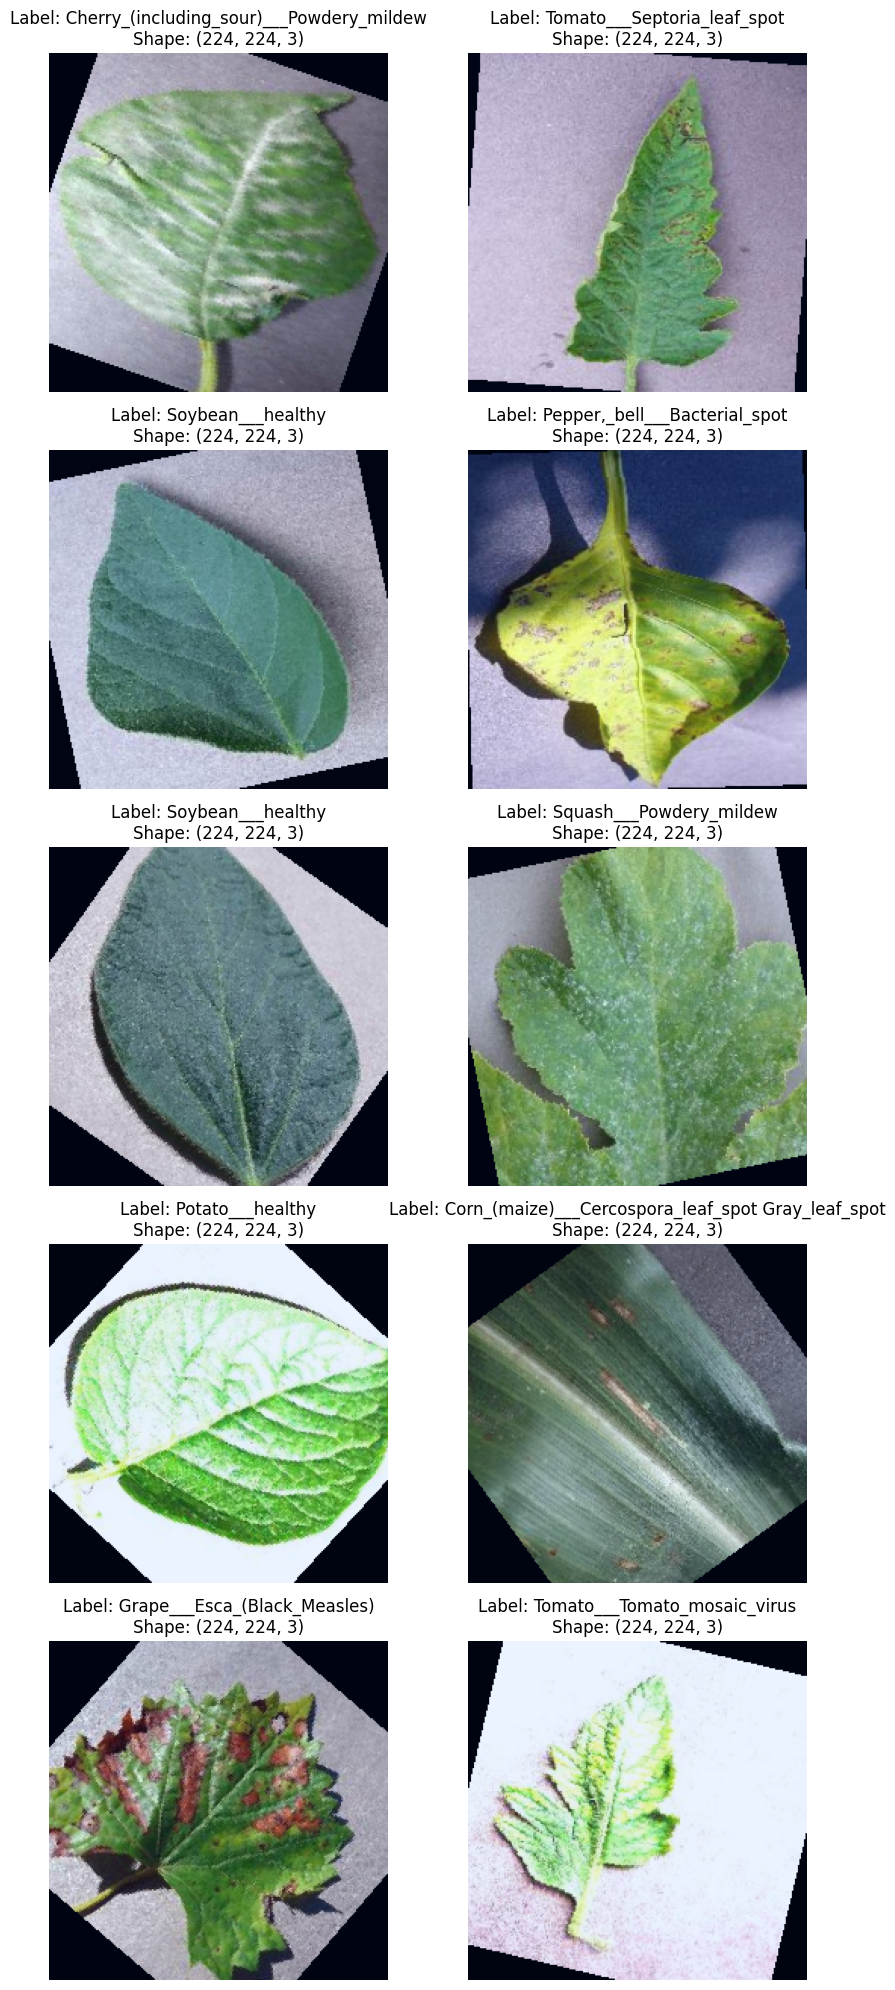

In [24]:
# visualize the sample of train dataloader
batch_images, batch_labels = next(iter(train_dataloader_rn50))

# function for displaying 10 images randomly from dataloader
def display_images(images, labels, class_names, nrows=5, ncols=2):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 20))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) # normalization display to 0 - 1
        ax.imshow(img)
        # get class name from label
        label_idx = labels[i].item()
        class_name = class_names[label_idx]
        # display class name
        ax.set_title(f"Label: {class_name}\nShape: {img.shape}")
        ax.axis("off")
        plt.tight_layout()
    plt.show()

# display images
display_images(batch_images, batch_labels, train_dataset_rn50.classes)

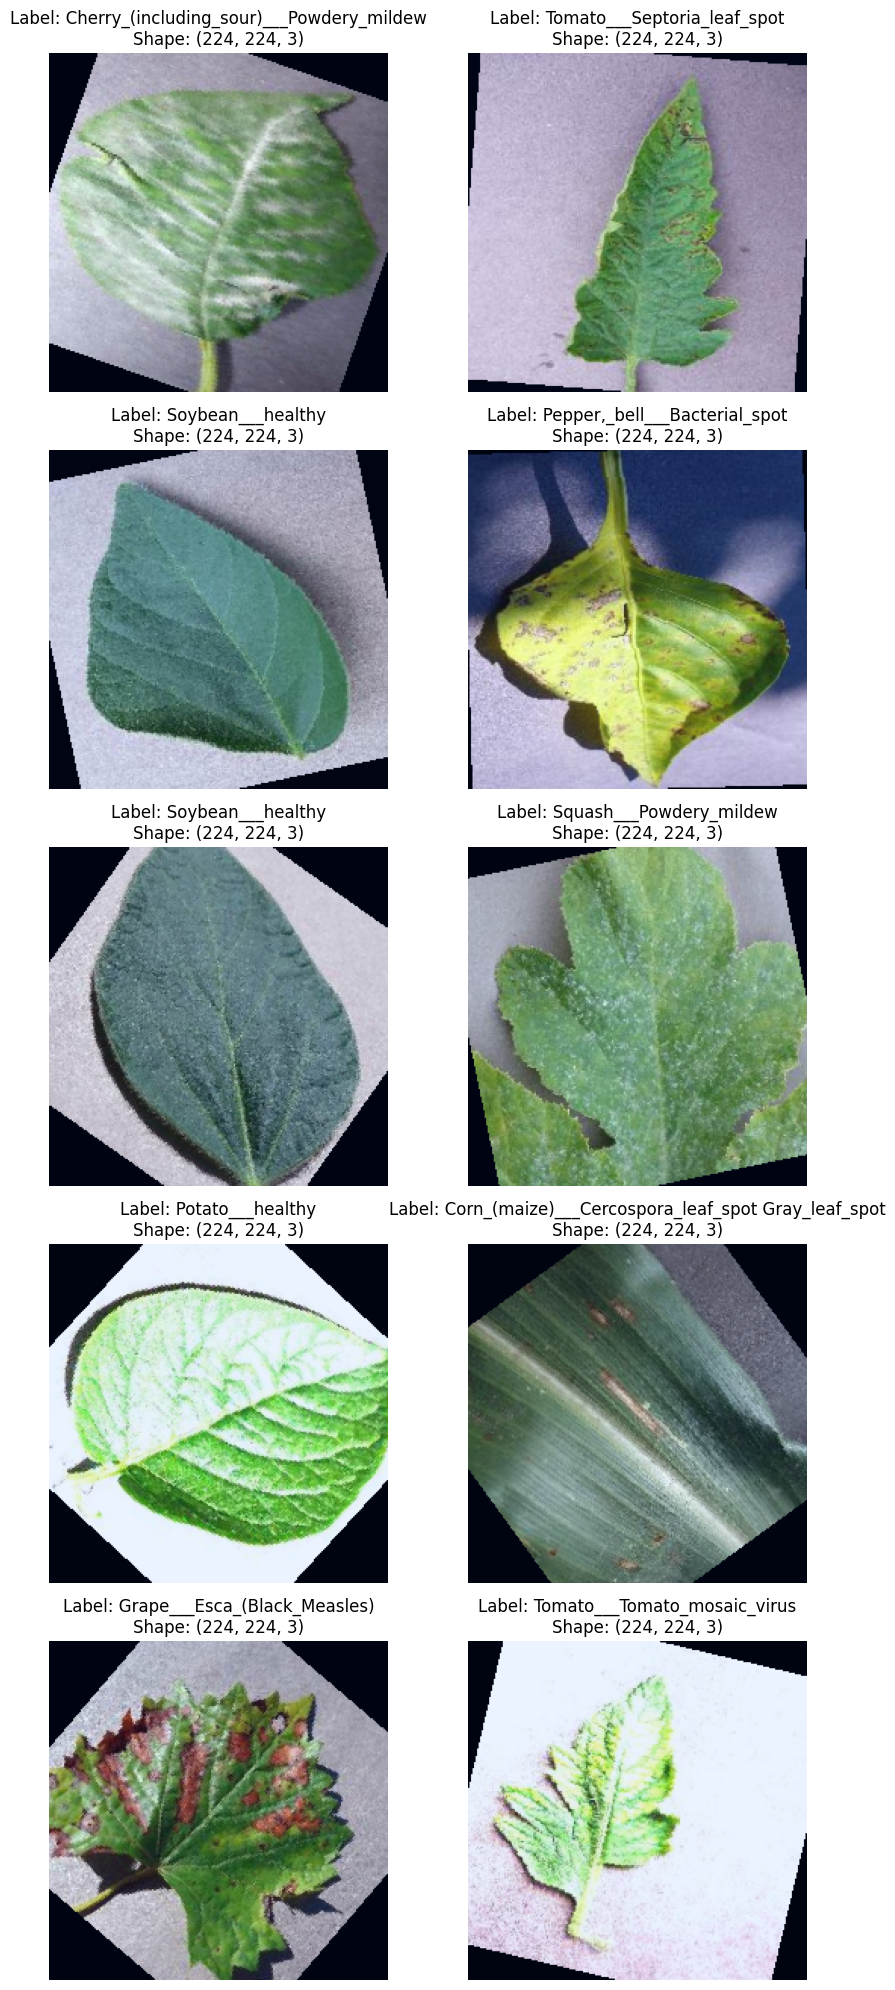

In [25]:
# batch_images, batch_labels = next(iter(train_dataloader_ev2))

# function for displaying 10 images randomly from dataloader
def display_images(images, labels, class_names, nrows=5, ncols=2):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 20))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) # normalization display to 0 - 1
        ax.imshow(img)
        # get class name from label
        label_idx = labels[i].item()
        class_name = class_names[label_idx]
        # display class name
        ax.set_title(f"Label: {class_name}\nShape: {img.shape}")
        ax.axis("off")
        plt.tight_layout()
    plt.show()

# display images
display_images(batch_images, batch_labels, train_dataset_ev2.classes)

In [26]:
rn50_model = resnet50(weights=ResNet50_Weights.DEFAULT)

# modify fully connected layer
rn50_model.fc = nn.Sequential(nn.Linear(in_features=rn50_model.fc.in_features, out_features=38))

# freeze pre-trained layers
for param in rn50_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in rn50_model.fc.parameters():
    param.requires_grad = True

# put model into device
rn50_model = rn50_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


In [27]:
summary(model=rn50_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 38]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [28]:
# load pre-trained EfficientNet V2 model: EfficientNet_V2_S_Weights.IMAGENET1K_V1
ev2_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

# modify fully connected layer
ev2_model.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=38))

# freeze pre-trained layers
for param in ev2_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in ev2_model.classifier.parameters():
    param.requires_grad = True

# put model into device
ev2_model = ev2_model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 222MB/s]


In [29]:
# display EfficientNet V2 model summary
summary(model=ev2_model,
        input_size=(32, 3, 384, 384),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 38]             --                   Partial
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 

In [30]:
# use CrossEntropyLoss() for multiclass classification task
loss_fn = nn.CrossEntropyLoss()

In [31]:
# Adam optimizer
optim_rn50 = Adam(params=rn50_model.parameters(), lr=0.00)
optim_ev2 = Adam(params=ev2_model.parameters(), lr=0.001)

In [32]:
# train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # put model in train mode
    model.train()

    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)

        # 2. calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # 6. calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [33]:
def val_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module):
    # put model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # turn on inference context manager
    with torch.inference_mode():
        # loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            val_pred_logits = model(X)

            # 2. calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # 3. calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [34]:
def train_process(model: torch.nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  val_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
                  epochs: int = 5):

    # 2. create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # 3. loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn)
 # 4. print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. return the filled results at the end of the epochs
    return results

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# start the timer
start_time = timer()

# train fine tuning ResNet50 model
rn50_results = train_process(model=rn50_model,
                             train_dataloader=train_dataloader_rn50,
                             val_dataloader=val_dataloader_rn50,
                             optimizer=optim_rn50,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS)

# end the timer and print out how long it took
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6499 | train_acc: 0.0219 | val_loss: 3.6485 | val_acc: 0.0254
Epoch: 2 | train_loss: 3.6502 | train_acc: 0.0221 | val_loss: 3.6485 | val_acc: 0.0255
Epoch: 3 | train_loss: 3.6502 | train_acc: 0.0222 | val_loss: 3.6488 | val_acc: 0.0261
Epoch: 4 | train_loss: 3.6508 | train_acc: 0.0222 | val_loss: 3.6486 | val_acc: 0.0255
Epoch: 5 | train_loss: 3.6502 | train_acc: 0.0217 | val_loss: 3.6485 | val_acc: 0.0251
Total Training Time: 1149.777 seconds


In [36]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# start the timer
start_time = timer()

# train fine tuning ResNet50 model
ev2_results = train_process(model=ev2_model,
                            train_dataloader=train_dataloader_ev2,
                            val_dataloader=val_dataloader_ev2,
                            optimizer=optim_ev2,
                            loss_fn=loss_fn,
                            epochs=NUM_EPOCHS)

# end the timer and print out how long it took
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6328 | train_acc: 0.8701 | val_loss: 0.2905 | val_acc: 0.9276
Epoch: 2 | train_loss: 0.2661 | train_acc: 0.9258 | val_loss: 0.2053 | val_acc: 0.9420
Epoch: 3 | train_loss: 0.2234 | train_acc: 0.9335 | val_loss: 0.1838 | val_acc: 0.9446
Epoch: 4 | train_loss: 0.2017 | train_acc: 0.9373 | val_loss: 0.1624 | val_acc: 0.9499
Epoch: 5 | train_loss: 0.1848 | train_acc: 0.9416 | val_loss: 0.1623 | val_acc: 0.9500
Total Training Time: 2563.792 seconds


In [37]:
# creat plot function for display result of training process
def plot_loss_curves(results: Dict[str, List[float]], suptitle=None, save="graph.jpg"):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # get the loss values of the results dictionary (training and validation)
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    # get the accuracy values of the results dictionary (training and validation)
    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    # figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

 # setup a plot
    plt.figure(figsize=(12, 4))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.suptitle(suptitle)
    
    # save graph
    plt.savefig(save)

    plt.show()

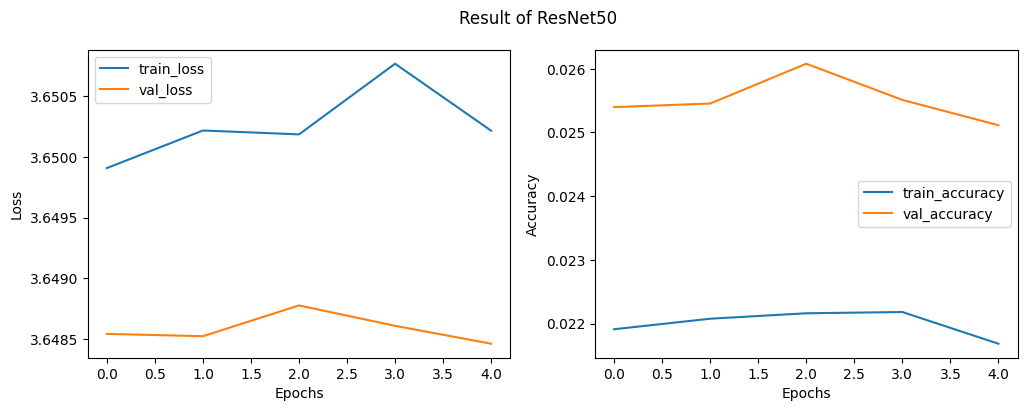

In [38]:
# plotting loss and accuracy from ResNet50 model results
plot_loss_curves(rn50_results, suptitle="Result of ResNet50", save="Result of ResNet50.jpg")

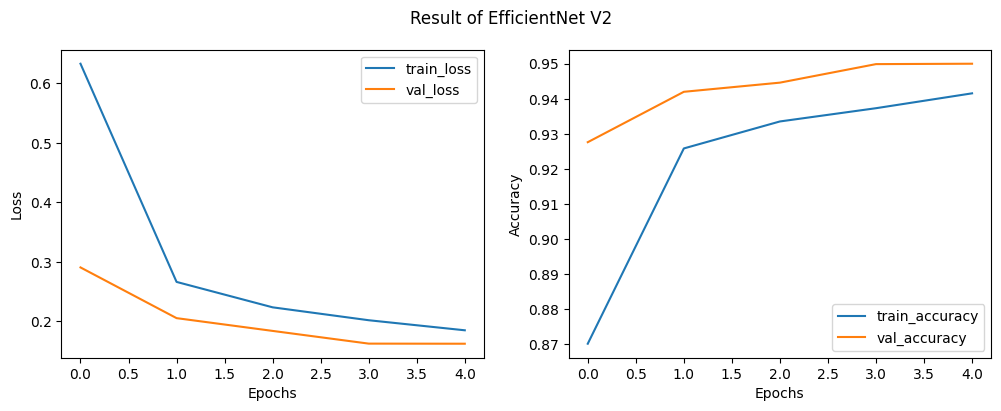

In [39]:
# plotting loss and accuracy from EfficientNet V2 model results
plot_loss_curves(ev2_results, suptitle="Result of EfficientNet V2", save="Result of EfficientNet V2.jpg")

In [40]:
# 1. create models directory
model_path = Path("/kaggle/working/")
model_path.mkdir(parents=True, exist_ok=True)

# 2. create model save path
model_name = "01_plant_diseases_classification_pytorch_rn50.pth"
model_save_path = model_path / model_name

# 3. save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=rn50_model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: /kaggle/working/01_plant_diseases_classification_pytorch_rn50.pth


In [41]:
# making prediction on single image

# load the trained ResNet50 model
# do not put model into device
path_model = "/kaggle/working/01_plant_diseases_classification_pytorch_rn50.pth"
model = resnet50(weights=None)
model.fc = nn.Sequential(nn.Linear(in_features=model.fc.in_features, out_features=38))
model.load_state_dict(torch.load(path_model))
model.eval()

# define class labels
class_labels = train_dataset_rn50.classes

# define the transfomation for the test images (same as transformation for validation data)
preprocess = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    # do not augment in test data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# prediction function on single image
def predict_image(image_path, model):
    # open and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)  # add batch dimension

    # make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        predicted_label = class_labels[predicted.item()]

    # display the image with prediction and confidence
    plt.imshow(image)
    plt.title(f"Prediction: {predicted_label}, Confidence: {confidence[predicted.item()]:.2f}%")
    plt.axis("off")
    plt.show()

<ipython-input-41-222468b5edcb>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_model))


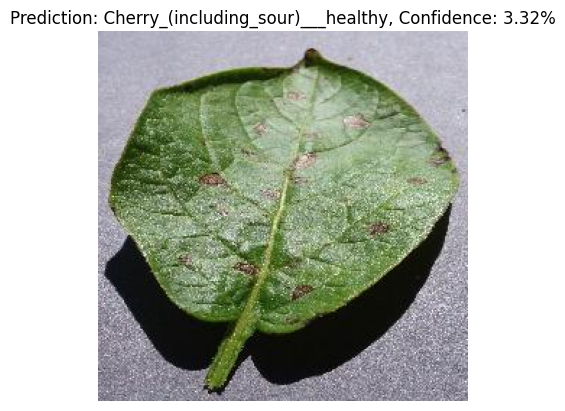

In [42]:
image_path = "/kaggle/input/new-plant-diseases-dataset/test/test/PotatoEarlyBlight5.JPG"
predict_image(image_path, model)

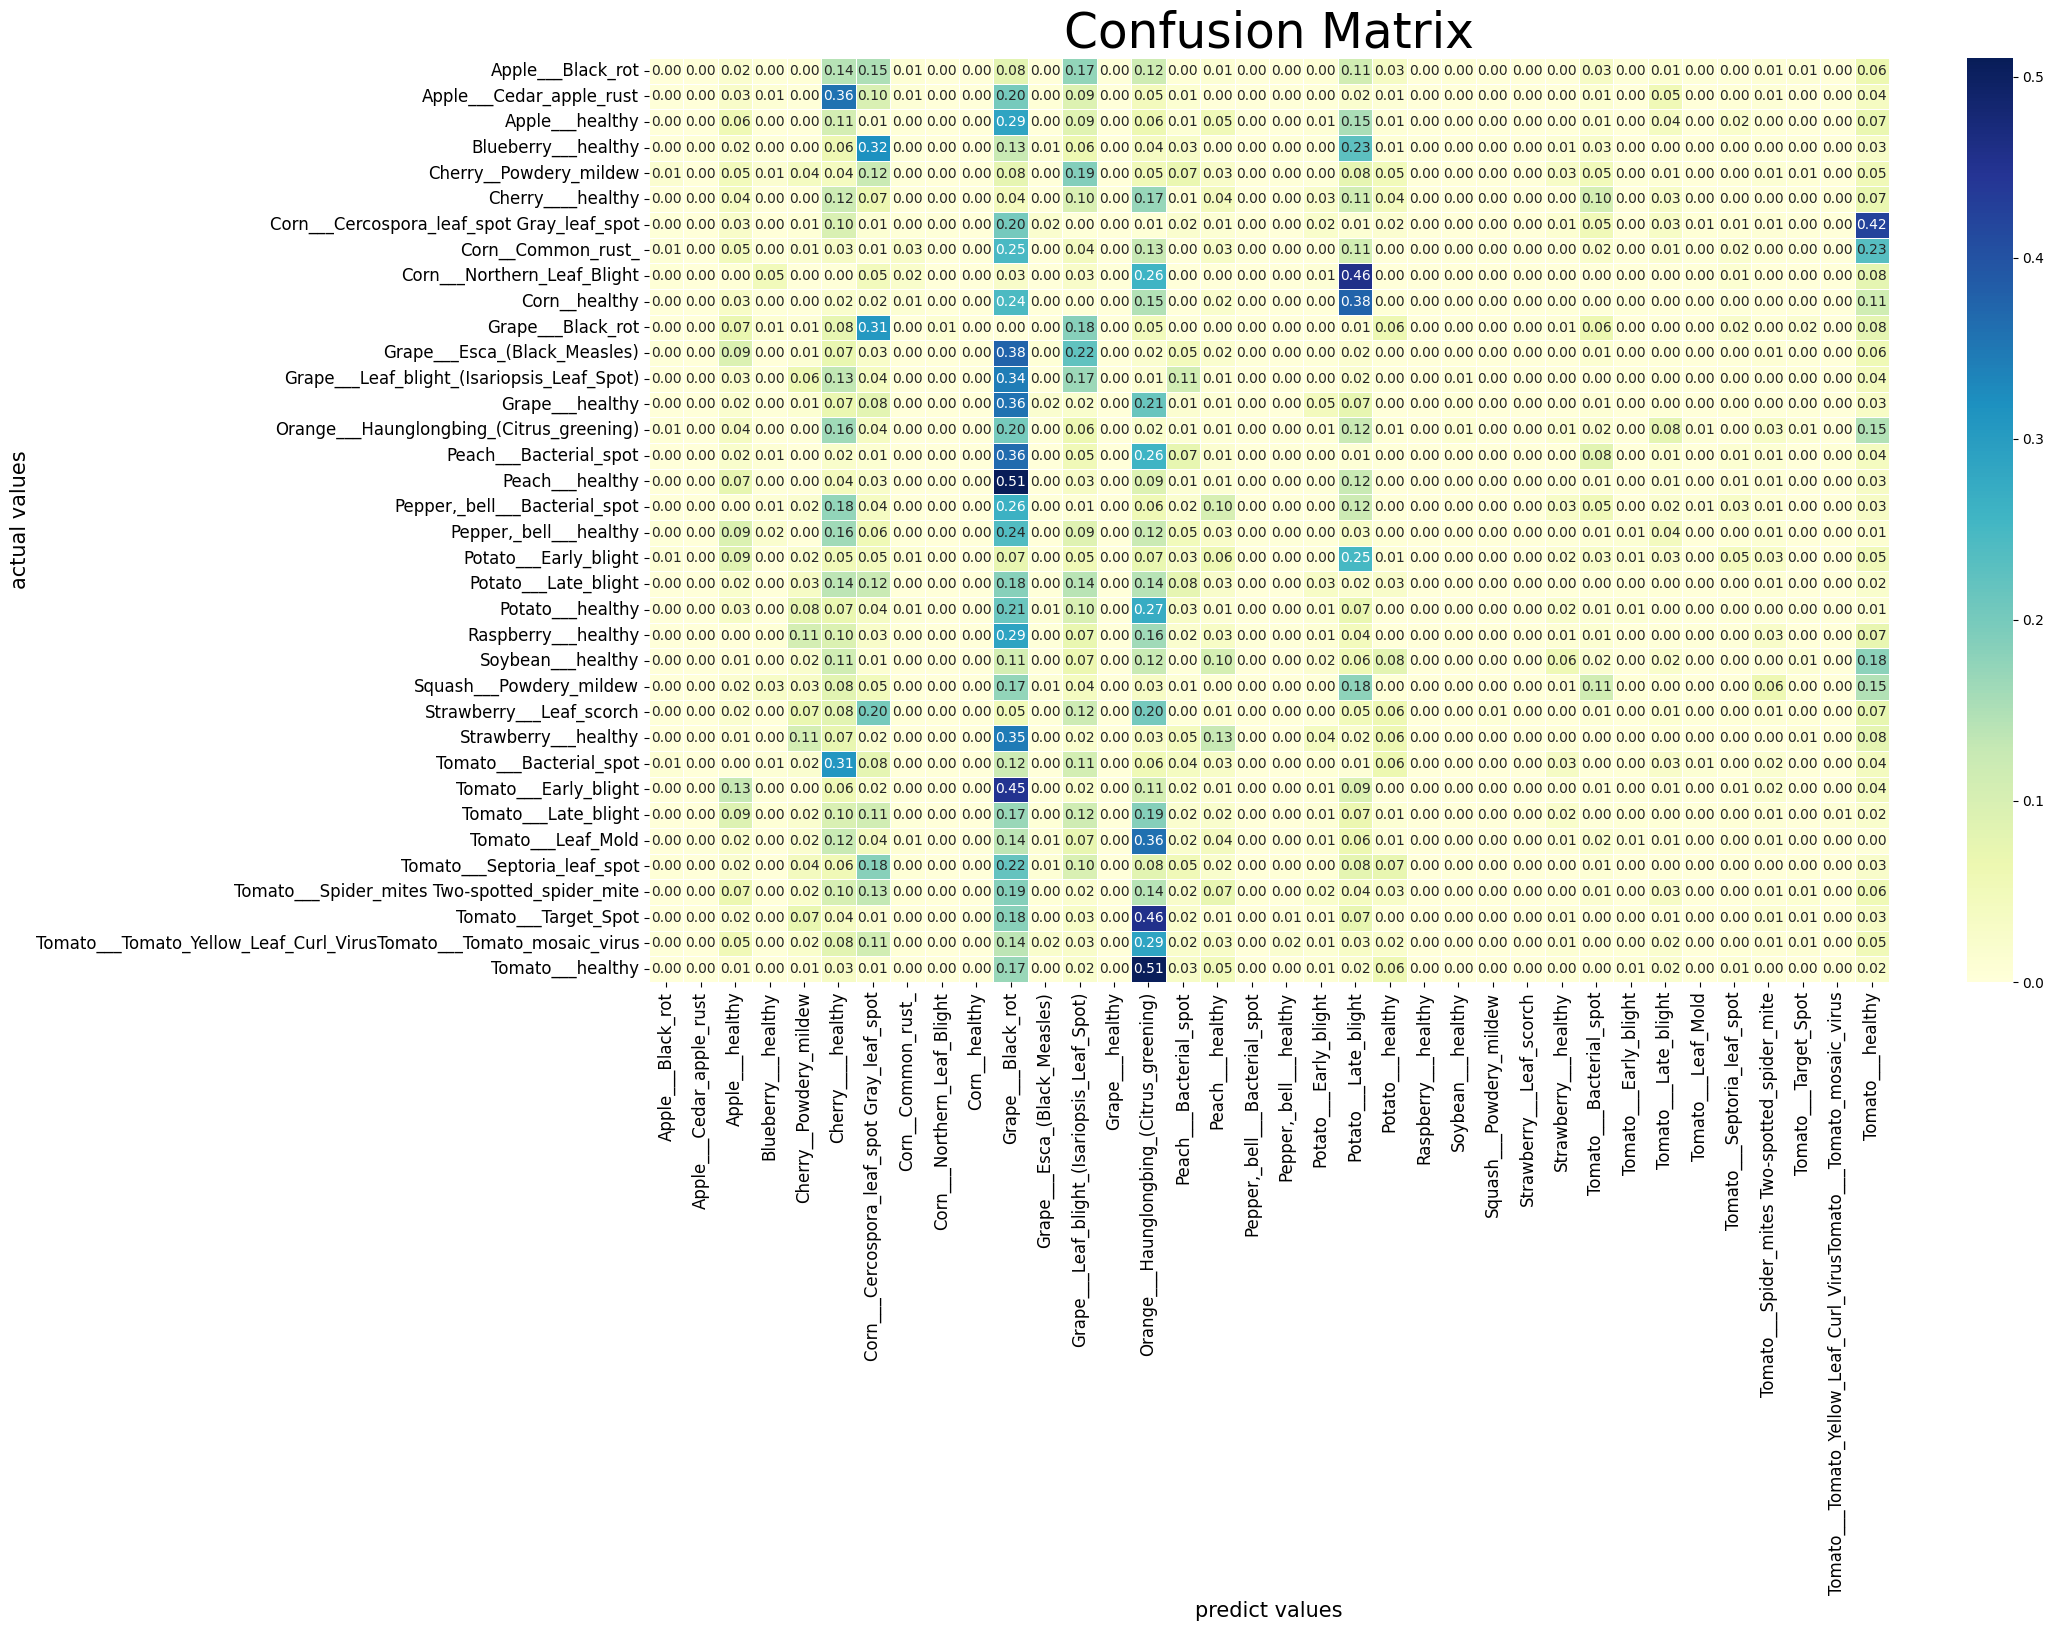

In [43]:
model = model.to(device)  # Transfer model to the GPU
model.eval()  # Set model to evaluation mode
model = model.to(device)  # Ensure model is on the GPU

y_true, y_preds = [], []

with torch.no_grad():
    for inputs, labels in val_dataloader_ev2:
        inputs, labels = inputs.to(device), labels.to(device)  # Transfer data to GPU
        outputs = model(inputs)  # Perform forward pass
        _, preds = torch.max(outputs, 1)  # Get predicted class
        y_true.extend(labels.cpu().numpy())  # Transfer labels to CPU and append
        y_preds.extend(preds.cpu().numpy())  # Transfer predictions to CPU and append
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import torch

# Assuming you have a validation set loader:
y_true = [10, 31, 7, 22, 4, 12, 19, 27, 11, 32, 7, 19, 8, 36, 29, 4, 20, 18, 11, 4, 30, 21, 25, 26, 7, 15, 0, 29, 29, 4, 5, 2]
y_preds = [31, 23, 31, 17, 36, 31, 26, 30, 14, 35, 2, 11, 30, 31, 30, 36, 19, 3, 27, 19, 18, 20, 2, 21, 2, 3, 23, 34, 37, 28, 18, 19]

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for inputs, labels in val_dataloader_ev2:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get predicted class
        y_true.extend(labels.cpu().numpy())
        y_preds.extend(preds.cpu().numpy())

# List of 38 class names
CLASSES = [
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry__Powdery_mildew',
 'Cherry____healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn__Common_rust_',
 'Corn___Northern_Leaf_Blight',
 'Corn__healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy'
    # Add all remaining class names...
]

# Create confusion matrix
train_cfn_matrix = confusion_matrix(y_true, y_preds, labels=range(len(CLASSES)))

# Normalize confusion matrix by row (actual class)
train_cfn_matrix = (train_cfn_matrix.T / train_cfn_matrix.sum(axis=1)).T

# Convert to pandas DataFrame for seaborn heatmap
train_df_cm = pd.DataFrame(train_cfn_matrix, index=CLASSES, columns=CLASSES)

# Plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
sns.heatmap(
    train_df_cm, cmap='YlGnBu', annot=True, fmt='.2f', linewidths=.5, ax=ax
)
ax.set_title('Confusion Matrix', fontsize=35)
ax.set_xlabel('predict values',fontsize=15)
ax.set_ylabel('actual values',fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12, rotation=0)
plt.show()